In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
cd drive/MyDrive/CNN

/content/drive/MyDrive/CNN


In [3]:
import os, shutil, random
from tqdm.notebook import tqdm

# 1. 폴더 정리

* 제공해드린 animals10.zip의 압축을 풀어 그 내용을 살펴보시고, 폴더 구조를 학습에 알맞도록 재구성해주세요
* 특히 각 클래스마다 약 30% 정도의 이미지를 test 폴더에 할당해주세요
* 중간중간 헷갈리다면 이것저것 확인하는 코드를 거쳐보세요 (ex. flat_test[:5]로 앞의 다섯값 확인)
* 궁금한 점이 있을 경우, 슬랙 질문 채널 활용을 적극 권장합니다.

In [4]:
### Guideline for convenience ###
# 압축 풀기

!unzip -qq "animals10.zip"

In [5]:
# 각 클래스별 파일 개수 확인 -> 변수로 해당 개수 저장
# Tip) 클래스가 10개이므로 각 클래스마다 똑같은 내용의 코드를 계속 써야할까요? 클래스 이름을 리스트로 저장해 for문을 돌리면서 코드를 재사용하는건 어떨까요?
name_num = dict()
compress_path = os.path.join(os.getcwd(), 'Animals-10')
for i in tqdm(os.listdir(compress_path)):
    path = os.path.join(compress_path, i)
    count = 0
    for j in os.listdir(path):
        count += 1
    name_num[i] = count

  0%|          | 0/10 [00:00<?, ?it/s]

In [6]:
name_num

{'butterfly': 2112,
 'cat': 1668,
 'chicken': 3098,
 'cow': 1866,
 'dog': 4863,
 'elephant': 1446,
 'horse': 2623,
 'sheep': 1820,
 'spider': 4821,
 'squirrel': 1862}

In [7]:
# test에 넣을 이미지 개수 계산 
ntest = []
for key, val in name_num.items():
    ntest.append(int(val * 0.3))

In [8]:
sum(ntest)

7848

In [9]:
# train, test 폴더 경로 선언 & 만들기
os.makedirs('animal_train', exist_ok = True)
os.makedirs('animal_test', exist_ok = True)
train_path = os.path.join(os.getcwd(), 'animal_train')
test_path = os.path.join(os.getcwd(), 'animal_test')

In [10]:
for i in name_num.keys():
    os.makedirs(os.path.join(train_path, i), exist_ok =True)
    os.makedirs(os.path.join(test_path, i), exist_ok =True)

In [11]:
compress_path

'/content/drive/MyDrive/CNN/Animals-10'

In [12]:
# train, test 폴더로 이미지 split해서 알맞게 집어넣기
test_, train_ = [], []
for idx, i in enumerate(tqdm(name_num.keys())):
    path = os.path.join(compress_path, i)
    test_img = random.sample(os.listdir(path), ntest[idx])
    train_img = [j for j in os.listdir(path) if j not in test_img]
    
    for k in tqdm(train_img):
        shutil.copy(os.path.join(path, k), os.path.join(train_path, i))

    for k in tqdm(test_img):
        shutil.copy(os.path.join(path, k), os.path.join(test_path, i))

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/1479 [00:00<?, ?it/s]

  0%|          | 0/633 [00:00<?, ?it/s]

  0%|          | 0/1168 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/2169 [00:00<?, ?it/s]

  0%|          | 0/929 [00:00<?, ?it/s]

  0%|          | 0/1307 [00:00<?, ?it/s]

  0%|          | 0/559 [00:00<?, ?it/s]

  0%|          | 0/3405 [00:00<?, ?it/s]

  0%|          | 0/1458 [00:00<?, ?it/s]

  0%|          | 0/1013 [00:00<?, ?it/s]

  0%|          | 0/433 [00:00<?, ?it/s]

  0%|          | 0/1837 [00:00<?, ?it/s]

  0%|          | 0/786 [00:00<?, ?it/s]

  0%|          | 0/1274 [00:00<?, ?it/s]

  0%|          | 0/546 [00:00<?, ?it/s]

  0%|          | 0/3375 [00:00<?, ?it/s]

  0%|          | 0/1446 [00:00<?, ?it/s]

  0%|          | 0/1304 [00:00<?, ?it/s]

  0%|          | 0/558 [00:00<?, ?it/s]

# 2. CNN 모델
수업 코드에 '모델 성능에 대한 고민!!' 부분을 참고해서 **test 이미지 기준 최소 80% 이상**의 모델이 나올 수 있도록 학습을 진행해주세요.
* 중간중간 헷갈리다면 이것저것 확인하는 코드를 거쳐보세요
* 90% 이상의 모델이 이상적이긴 합니다
* 궁금한 점이 있을 경우, 슬랙 질문 채널 활용을 적극 권장합니다.

전반적으로 수업 코드와 비슷하게 짜면 되는데, 생각해봐야 할 것은
* 모든 이미지를 내가 정의하는 하나의 모델에 넣어야함
* 그말은 input 데이터의 차원이 항상 동일해야 된다는 말
* 그런데 과연 내가 가지고 있는 이미지들의 사이즈가 모두 같을까? - 대략 얼마정도 사이즈 가지고 있는지 코드로 확인해보면 더 좋음 (shape 확인)
* 이미지 사이즈를 통일시키기 위해서는 어떻게 해야할까? - transforms의 Resize, RandomCrop 써볼까?
* 동물 이미지에 적합한 Augmentation은 무엇이 있을까?

In [54]:
from PIL import Image

import numpy as np
import matplotlib.pyplot as plt

import torch
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
import torch.nn as nn
from torchsummary import summary


In [55]:
# train, test 이미지를 위한 transforms function 정의
# 위에서 말한 포인트들 생각해보기 - 차원에 유의하자!

In [15]:
# 이상한 데이터 삭제
for j in tqdm(os.listdir(train_path)):
    path_ = os.path.join(train_path, j)
    for i in tqdm(os.listdir(path_)):
        p = os.path.join(path_, i)
        image = Image.open(p)
        ten = transforms.ToTensor()(image)
        if ten.shape[0] != 3:
            print(i, ten.shape)
            os.remove(p)

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/1479 [00:00<?, ?it/s]

butterfly (1).png torch.Size([4, 533, 640])
butterfly (10).png torch.Size([4, 526, 640])
butterfly (11).png torch.Size([4, 481, 640])
butterfly (12).png torch.Size([4, 378, 640])
butterfly (13).png torch.Size([4, 454, 640])
butterfly (16).png torch.Size([4, 581, 640])
butterfly (17).png torch.Size([4, 360, 640])
butterfly (19).png torch.Size([4, 539, 640])
butterfly (2).png torch.Size([4, 416, 640])
butterfly (21).png torch.Size([4, 565, 640])
butterfly (23).png torch.Size([4, 450, 640])
butterfly (24).png torch.Size([4, 436, 640])
butterfly (26).png torch.Size([4, 480, 640])
butterfly (27).png torch.Size([4, 519, 640])
butterfly (29).png torch.Size([4, 378, 640])
butterfly (3).png torch.Size([4, 375, 640])
butterfly (30).png torch.Size([4, 487, 640])
butterfly (31).png torch.Size([4, 348, 640])
butterfly (33).png torch.Size([4, 426, 640])
butterfly (34).png torch.Size([4, 640, 480])
butterfly (35).png torch.Size([4, 402, 640])
butterfly (36).png torch.Size([4, 640, 469])
butterfly (38

  0%|          | 0/1168 [00:00<?, ?it/s]

cat (1).png torch.Size([4, 402, 640])


  0%|          | 0/2169 [00:00<?, ?it/s]

  0%|          | 0/1307 [00:00<?, ?it/s]

  0%|          | 0/3405 [00:00<?, ?it/s]

  0%|          | 0/1013 [00:00<?, ?it/s]

elephant (1).png torch.Size([4, 341, 640])
elephant (2).png torch.Size([4, 426, 640])
elephant (3).png torch.Size([4, 640, 480])
elephant (5).png torch.Size([4, 512, 640])
elephant (6).png torch.Size([4, 512, 640])
elephant (7).png torch.Size([4, 512, 640])
elephant (8).png torch.Size([4, 480, 640])
elephant (81).jpg torch.Size([4, 426, 640])


  0%|          | 0/1837 [00:00<?, ?it/s]

  0%|          | 0/1274 [00:00<?, ?it/s]

  0%|          | 0/3375 [00:00<?, ?it/s]

spider (2).png torch.Size([4, 426, 640])


  0%|          | 0/1304 [00:00<?, ?it/s]

In [17]:
for j in tqdm(os.listdir(test_path)):
    path_ = os.path.join(test_path, j)
    for i in tqdm(os.listdir(path_)):
        p = os.path.join(path_, i)
        image = Image.open(p)
        ten = transforms.ToTensor()(image)
        if ten.shape[0] != 3:
            print(i, ten.shape)
            os.remove(p)

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/633 [00:00<?, ?it/s]

butterfly (22).png torch.Size([4, 630, 640])
butterfly (18).png torch.Size([4, 368, 640])
butterfly (20).png torch.Size([4, 378, 640])
butterfly (25).png torch.Size([4, 640, 640])
butterfly (37).png torch.Size([4, 533, 640])
butterfly (28).png torch.Size([4, 496, 640])
butterfly (14).png torch.Size([4, 454, 640])
butterfly (32).png torch.Size([4, 577, 640])
butterfly (15).png torch.Size([4, 640, 480])


  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/929 [00:00<?, ?it/s]

  0%|          | 0/559 [00:00<?, ?it/s]

  0%|          | 0/1458 [00:00<?, ?it/s]

  0%|          | 0/433 [00:00<?, ?it/s]

elephant (4).png torch.Size([4, 425, 640])
elephant (24).jpg torch.Size([1, 493, 640])


  0%|          | 0/786 [00:00<?, ?it/s]

  0%|          | 0/546 [00:00<?, ?it/s]

  0%|          | 0/1446 [00:00<?, ?it/s]

  0%|          | 0/558 [00:00<?, ?it/s]

In [18]:
meanRGB = []
stdRGB = []
j = 0
for j in tqdm(os.listdir(train_path)):
    path_ = os.path.join(train_path, j)
    for i in tqdm(os.listdir(path_)):
        p = os.path.join(path_, i)
        image = Image.open(p)
        ten = transforms.ToTensor()(image)
        meanRGB.append(ten.mean([1, 2]))
        stdRGB.append(ten.std([1, 2]))

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/1449 [00:00<?, ?it/s]

  0%|          | 0/1167 [00:00<?, ?it/s]

  0%|          | 0/2169 [00:00<?, ?it/s]

  0%|          | 0/1307 [00:00<?, ?it/s]

  0%|          | 0/3405 [00:00<?, ?it/s]

  0%|          | 0/1005 [00:00<?, ?it/s]

  0%|          | 0/1837 [00:00<?, ?it/s]

  0%|          | 0/1274 [00:00<?, ?it/s]

  0%|          | 0/3374 [00:00<?, ?it/s]

  0%|          | 0/1304 [00:00<?, ?it/s]

In [19]:
meanR = np.mean([m[0] for m in meanRGB])
meanG = np.mean([m[1] for m in meanRGB])
meanB = np.mean([m[2] for m in meanRGB])
stdR = np.mean([s[0] for s in stdRGB])
stdG = np.mean([s[1] for s in stdRGB])
stdB = np.mean([s[2] for s in stdRGB])

In [20]:
transform_train = transforms.Compose([
    transforms.ColorJitter(brightness=0.5),
    transforms.RandomHorizontalFlip(p = 0.5),
    transforms.RandomRotation(20),
    transforms.ToTensor(),
    transforms.Resize(224),
    transforms.CenterCrop(224),
    transforms.Normalize((meanR, meanG, meanB), (stdR, stdG, stdB))
])

transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Resize(224),
    transforms.CenterCrop(224),
    transforms.Normalize((meanR, meanG, meanB), (stdR, stdG, stdB))
])

In [21]:
# ImageFolder와 앞서 정의한 transforms function을 활용해 Dataset 객체 (train, test에 대해) 선언
train_data = torchvision.datasets.ImageFolder(
    root = './animal_train',
    transform = transform_train
)

test_data = torchvision.datasets.ImageFolder(
    root = './animal_test',
    transform = transform_test
)

In [22]:
# train, test에 대해 DataLoader 정의
trainloader = DataLoader(train_data, shuffle = True, batch_size = 64)
testloader = DataLoader(test_data, batch_size = 64)

In [59]:
### Model 클래스 정의 - 차원에 유의하자!
# 10개의 클래스를 분류해야 하는 꽤나 복잡한 task - 모델 구조를 어느 정도로 복잡하게 짜볼까?
# 가장 마지막 Linear의 out_features는 얼마로 해야할까?
class CustomCNN(nn.Module):
    def __init__(self):
        super(CustomCNN, self).__init__()

        self.layer = nn.Sequential(
            # 3, 224, 224
            nn.Conv2d(3, 16, 5, padding = 2),
            nn.BatchNorm2d(16),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Conv2d(16, 32, 5, padding = 2),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.MaxPool2d(2, 2),
            # 32, 112, 112
            nn.Conv2d(32, 64, 5, padding = 2),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.MaxPool2d(2, 2),
            # 64, 56, 56
            nn.Conv2d(64, 64, 5, padding = 2),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.MaxPool2d(2, 2),
            # 64, 28, 28
            nn.Conv2d(64, 32, 5, padding = 2),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.MaxPool2d(2, 2),
            # 32, 14, 14
            nn.Conv2d(32, 32, 5, padding = 2),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.MaxPool2d(2, 2)
            # 32, 7, 7
        )
        
        self.fc = nn.Sequential(
            nn.Linear(32 * 7 * 7, 100),
            nn.ReLU(),
            nn.Linear(100, 10)
        )
        
    def forward(self, x):
        out = self.layer(x)
        out = out.view(out.size(0), -1)
        out = self.fc(out)
        return out

In [60]:
# torchsummary로 모델 차원 어떻게 나오는지 돌려보기
test_model = CustomCNN()
summary(test_model, input_size = (3, 224, 224), batch_size = 64, device = 'cpu')

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [64, 16, 224, 224]           1,216
       BatchNorm2d-2         [64, 16, 224, 224]              32
              ReLU-3         [64, 16, 224, 224]               0
           Dropout-4         [64, 16, 224, 224]               0
            Conv2d-5         [64, 32, 224, 224]          12,832
       BatchNorm2d-6         [64, 32, 224, 224]              64
              ReLU-7         [64, 32, 224, 224]               0
           Dropout-8         [64, 32, 224, 224]               0
         MaxPool2d-9         [64, 32, 112, 112]               0
           Conv2d-10         [64, 64, 112, 112]          51,264
      BatchNorm2d-11         [64, 64, 112, 112]             128
             ReLU-12         [64, 64, 112, 112]               0
          Dropout-13         [64, 64, 112, 112]               0
        MaxPool2d-14           [64, 64,

In [61]:
# Device 선언 (GPU 권장)
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

In [69]:
# 모델 객체 선언
cnn1 = CustomCNN().to(device)

In [70]:
# loss func, optimizer 정의
criterion = nn.CrossEntropyLoss().to(device)
optimizer = torch.optim.Adam(cnn1.parameters(), lr = 0.001, weight_decay = 0.0001)

In [71]:
seq_train_loss = []
seq_test_loss = []
seq_train_acc = []
seq_test_acc = []

In [72]:
# train 함수 정의
def train(epoch):
    print(f'\n[ Train epoch: {epoch+1} ]')

    cnn1.train() # train은 항상 이걸 지정하고 시작! - Dropout, Batch Normalization 등의 효과를 적용하고 진행하기 위함

    running_loss = 0.0
    batch_losses = []
    total = 0
    correct = 0

    for batch_idx, (inputs, targets) in enumerate(trainloader):
        inputs, targets = inputs.to(device), targets.to(device) # dataloader의 input image와 label도 device에 넣어줘야됨
        
        # DL 학습 기본 코드
        optimizer.zero_grad() # gradient 초기화
        outputs = cnn1(inputs) # 현재 batch의 inputs을 모델에 넣어 outputs 추출 (확률값)
        loss = criterion(outputs, targets) # 추출한 outputs와 원래 label인 targets 사이 loss 계산
        loss.backward() # 계산한 loss 기반으로 gradient 값 계산
        optimizer.step() # weight parameter update

        total += targets.size(0) # batch 데이터 개수 더하기
        running_loss += loss.item()
        batch_losses.append(loss.item())
        
        _, predicted = outputs.max(1) # 확률값 가장 높게 나타난 클래스
        correct += (predicted == targets).sum().item() # 현재 batch 내에서 알맞게 분류한 이미지 개수 더하기
        
        if batch_idx % 50 == 49:
            print(f'\nCurrent batch: {str(batch_idx+1)}')
            print(f'Average train loss of recent 50 batches: {running_loss / 50}') # 이렇게 출력하는 것이 꼭 필요한 것은 아니지만, 중간중간 확인을 위해 매우 권장
            running_loss = 0.0

    avg_loss = sum(batch_losses) / len(batch_losses)
    seq_train_loss.append(avg_loss)
    seq_train_acc.append(100*correct/total)
    print('\nTotal train accuarcy:', 100. * correct / total) # 전체 데이터 개수에서 맞게 예측한 비율
    print('Total train loss:', avg_loss)

In [73]:
# test 함수 정의
def test(epoch):
    print(f'\n[ Test epoch: {epoch+1} ]')

    cnn1.eval() # eval은 항상 이걸 지정하고 시작! - Dropout, Batch Normalization 등의 효과를 적용하지 않기 위함!
                   # ex. evaluation 할때는 Dropout 없이 지금까지 학습한 모든 node를 활용해서 진행해야됨

    loss = 0
    batch_losses = []
    correct = 0
    total = 0

    with torch.no_grad(): # gradient update 안함 - eval과 torch.no_grad는 하나의 세트
        for batch_idx, (inputs, targets) in enumerate(testloader):
            inputs, targets = inputs.to(device), targets.to(device)

            outputs = cnn1(inputs)
            loss = criterion(outputs, targets)
            batch_losses.append(loss.item())

            total += targets.size(0)
            _, predicted = outputs.max(1)
            correct += (predicted == targets).sum().item()

    avg_loss = sum(batch_losses) / len(batch_losses)
    seq_test_loss.append(avg_loss)
    seq_test_acc.append(100 * correct / total)
    print('\nTest accuarcy:', 100. * correct / total)
    print('Test average loss:', avg_loss)

In [75]:
# num_epoch = 50
# for epoch in range(0, num_epoch):
#     train(epoch)
#     test(epoch)

# model 저장! - parameter값 저장
torch.save(cnn1.state_dict(), './mymodel_cifar10.pt')
print('Model Saved!')

Model Saved!


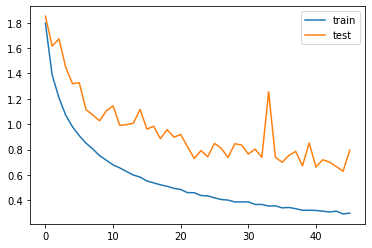

In [79]:
# loss, accuracy 추이 확인 with plt.plot
plt.plot(seq_train_loss, label = 'train')
plt.plot(seq_test_loss, label = 'test')
plt.legend()
plt.show()

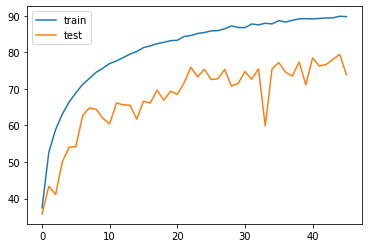

Maximum Test Accuracy : 79.4436646676024


In [81]:
plt.plot(seq_train_acc, label = 'train')
plt.plot(seq_test_acc, label = 'test')
plt.legend()
plt.show()
print('Maximum Test Accuracy :', max(seq_test_acc))